# Rossmann Sales Prediction using SARIMAX

In [2]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [10]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [11]:
df_train.shape

(1017209, 9)

In [12]:
df_train['Date'] = pd.to_datetime(df_train['Date'])

df_train['Year'] = df_train['Date'].dt.year
df_train['Month'] = df_train['Date'].dt.month
df_train['Day'] = df_train['Date'].dt.day
df_train['WeekOfYear'] = df_train['Date'].dt.isocalendar().week
df_train['SalePerCustomer'] = df_train['Sales']/df_train['Customers']
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   Store            1017209 non-null  int64         
 1   DayOfWeek        1017209 non-null  int64         
 2   Date             1017209 non-null  datetime64[ns]
 3   Sales            1017209 non-null  int64         
 4   Customers        1017209 non-null  int64         
 5   Open             1017209 non-null  int64         
 6   Promo            1017209 non-null  int64         
 7   StateHoliday     1017209 non-null  object        
 8   SchoolHoliday    1017209 non-null  int64         
 9   Year             1017209 non-null  int64         
 10  Month            1017209 non-null  int64         
 11  Day              1017209 non-null  int64         
 12  WeekOfYear       1017209 non-null  UInt32        
 13  SalePerCustomer  844340 non-null   float64       
dtypes:

In [14]:
df_store = pd.read_csv('/content/sample_data/store.csv')
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [15]:
df_joined = pd.merge(df_train, df_store, on='Store', how='inner')
df_joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,8.948214,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,9.970588,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [16]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   Year                       1017209 non-null  int64         
 10  Month                      1017209 non-null  int64         
 11  Day                        1017209 no

## Correlation Chart

<Axes: >

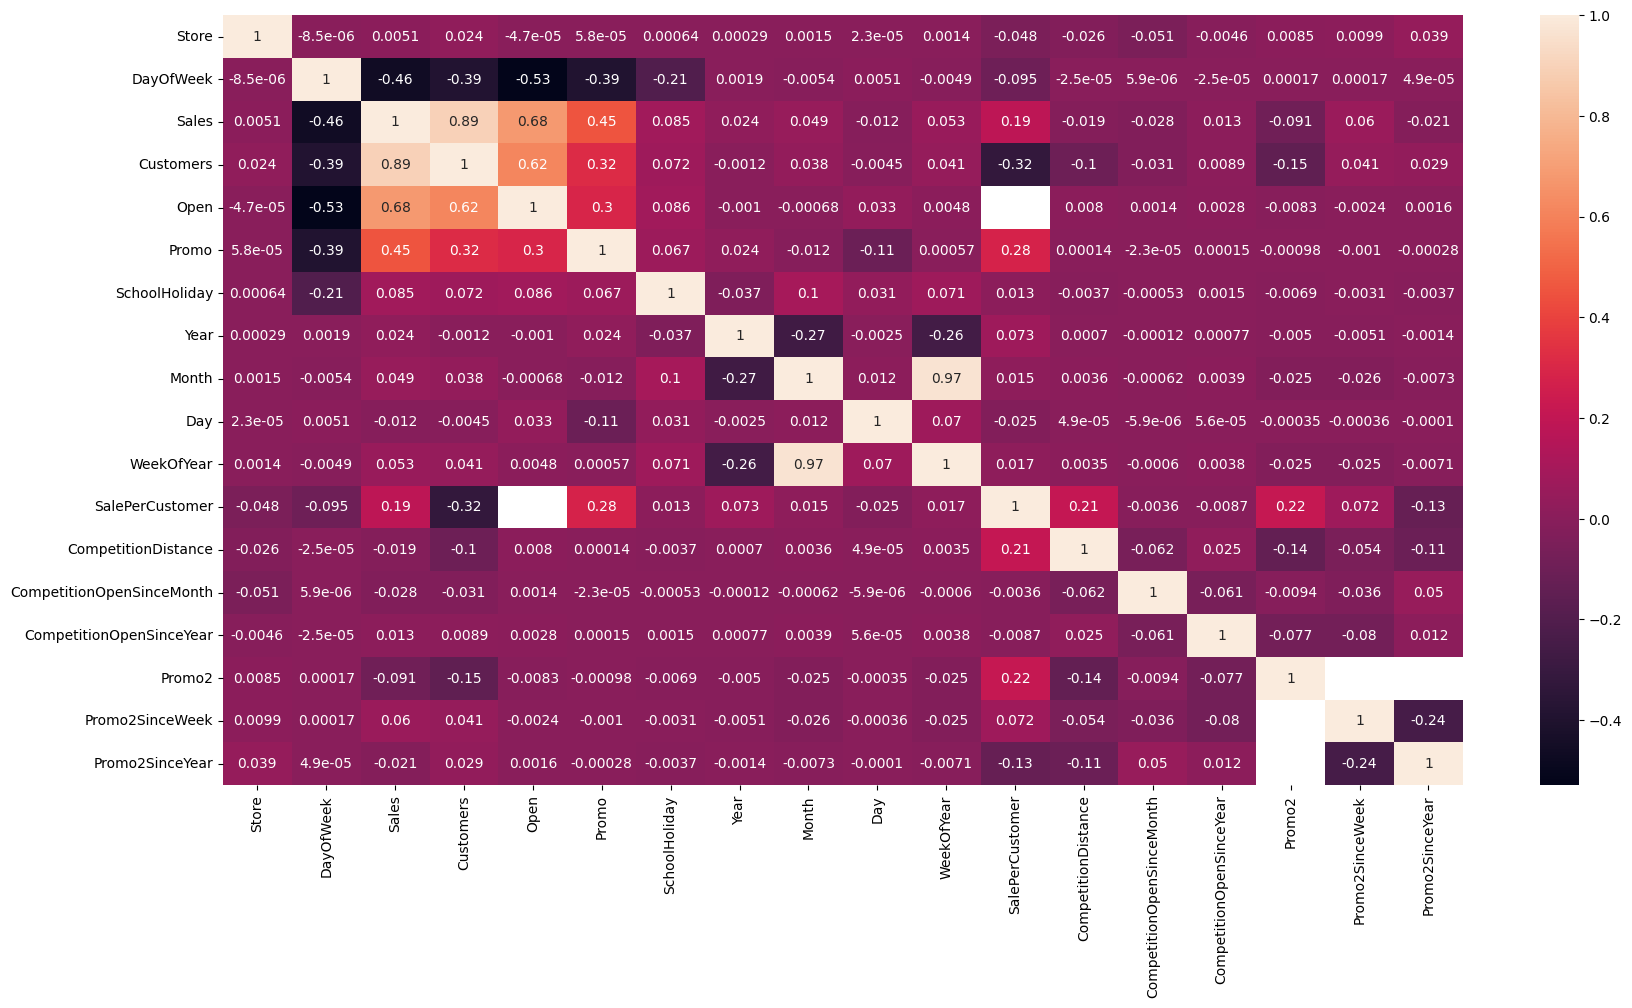

In [17]:
plt.figure(figsize = (20, 10))
sns.heatmap(df_joined.corr(), annot = True)

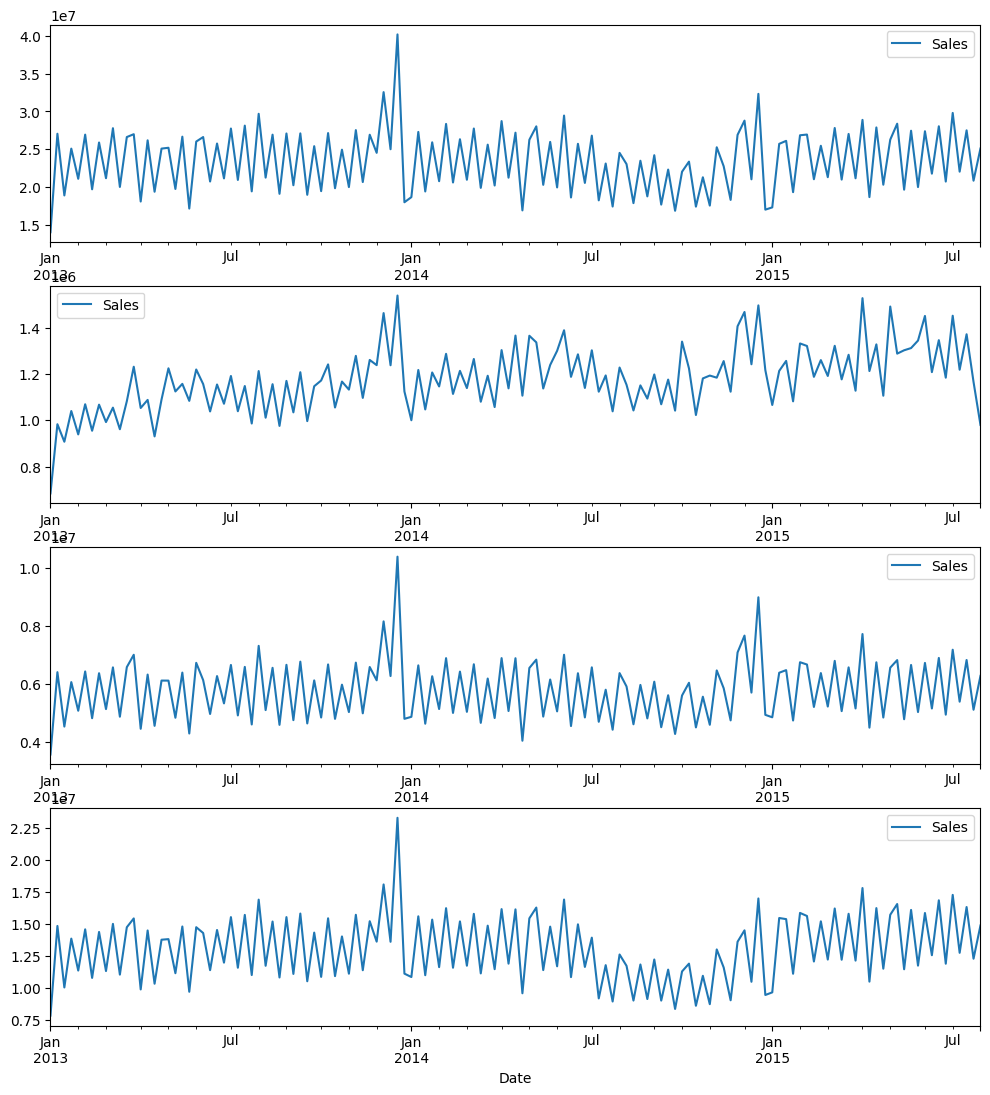

In [22]:
df_joined['Date'] = pd.to_datetime(df_joined['Date'])
df_joined['Sales'] = df_joined['Sales'] * 1.0
pd.plotting.register_matplotlib_converters()

df_store_a = df_joined[df_joined.StoreType == "a"][['Sales', 'Date']].set_index('Date')
df_store_b = df_joined[df_joined.StoreType == "b"][['Sales', 'Date']].set_index('Date')
df_store_c = df_joined[df_joined.StoreType == "c"][['Sales', 'Date']].set_index('Date')
df_store_d = df_joined[df_joined.StoreType == "d"][['Sales', 'Date']].set_index('Date')

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

df_store_a.resample('W').sum().plot(ax = ax1)
df_store_b.resample('W').sum().plot(ax = ax2)
df_store_c.resample('W').sum().plot(ax = ax3)
df_store_d.resample('W').sum().plot(ax = ax4)

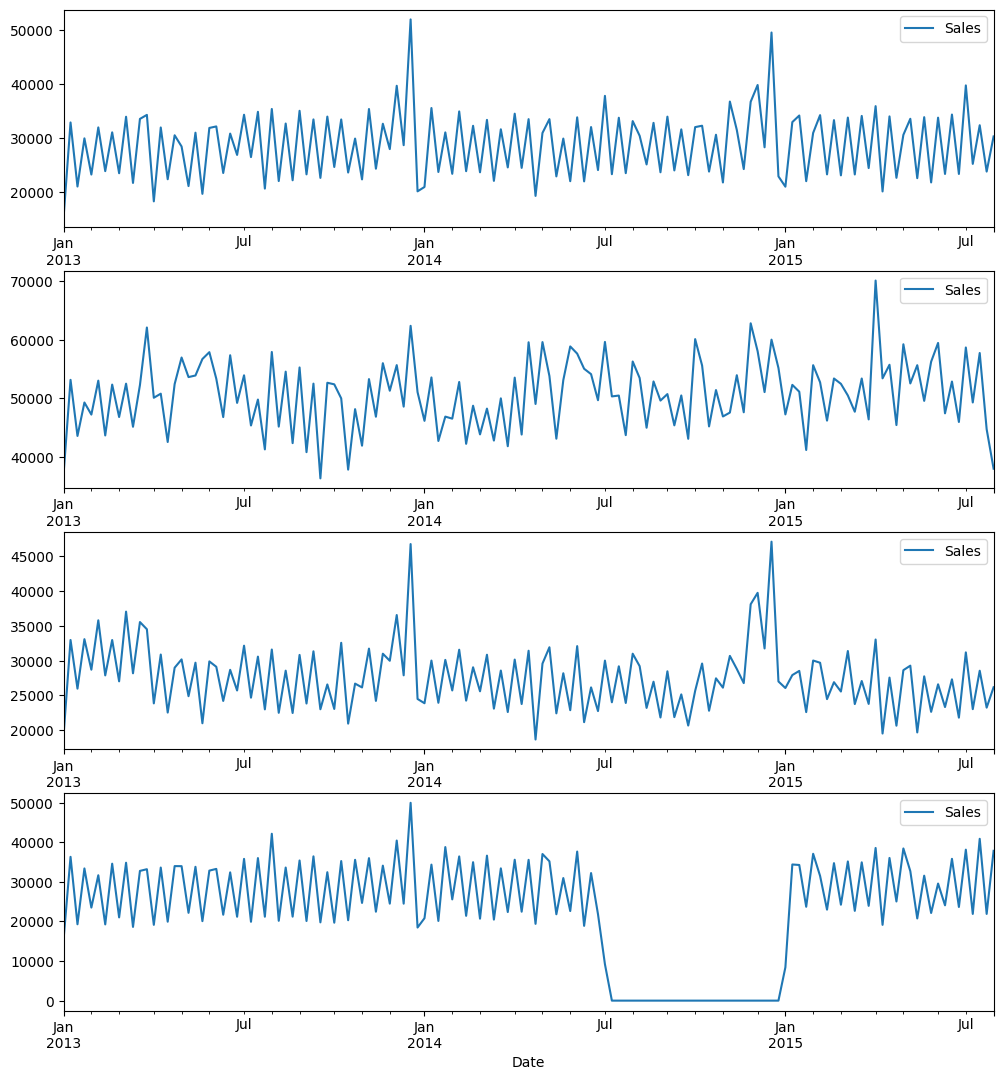

In [29]:
df_store_a_2 = df_joined[df_joined.Store == 2][['Sales', 'Date']].set_index('Date')
df_store_b_83 = df_joined[df_joined.Store == 85][['Sales', 'Date']].set_index('Date')
df_store_c_1 = df_joined[df_joined.Store == 1][['Sales', 'Date']].set_index('Date')
df_store_d_13 = df_joined[df_joined.Store == 13][['Sales', 'Date']].set_index('Date')

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

df_store_a_2.resample('W').sum().plot(ax = ax1)
df_store_b_83.resample('W').sum().plot(ax = ax2)
df_store_c_1.resample('W').sum().plot(ax = ax3)
df_store_d_13.resample('W').sum().plot(ax = ax4);

In [30]:
def test_stationarity(timeseries):

    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plotting rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

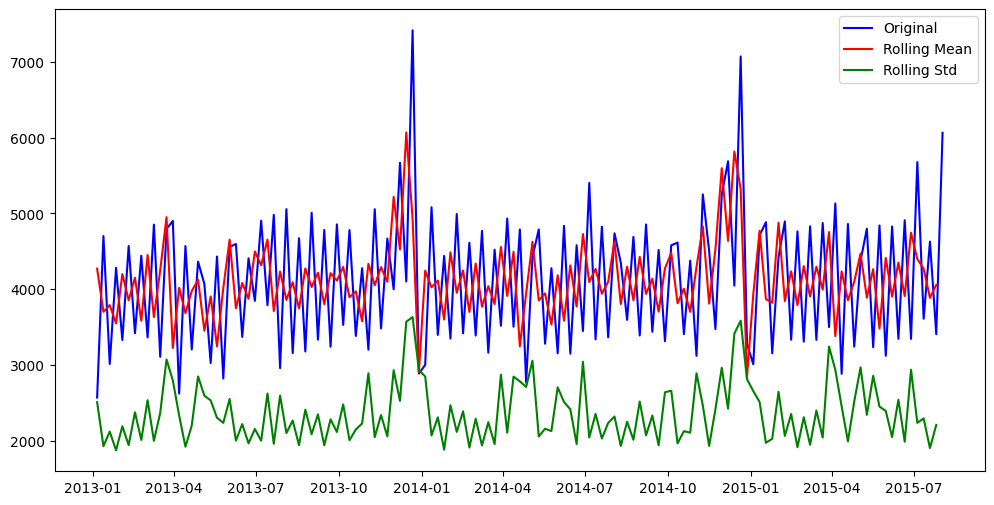

Results of Dickey-Fuller Test:
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


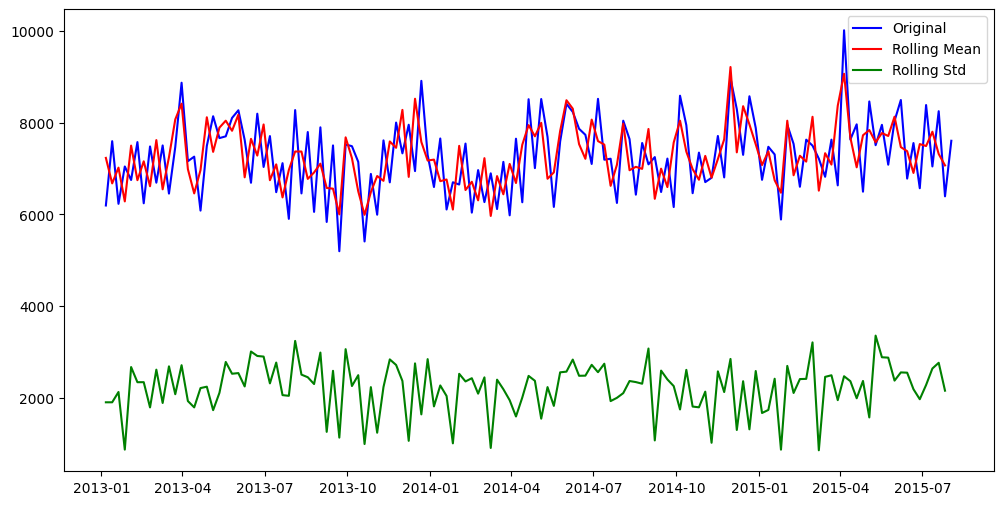

Results of Dickey-Fuller Test:
ADF Statistic: -5.589202
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


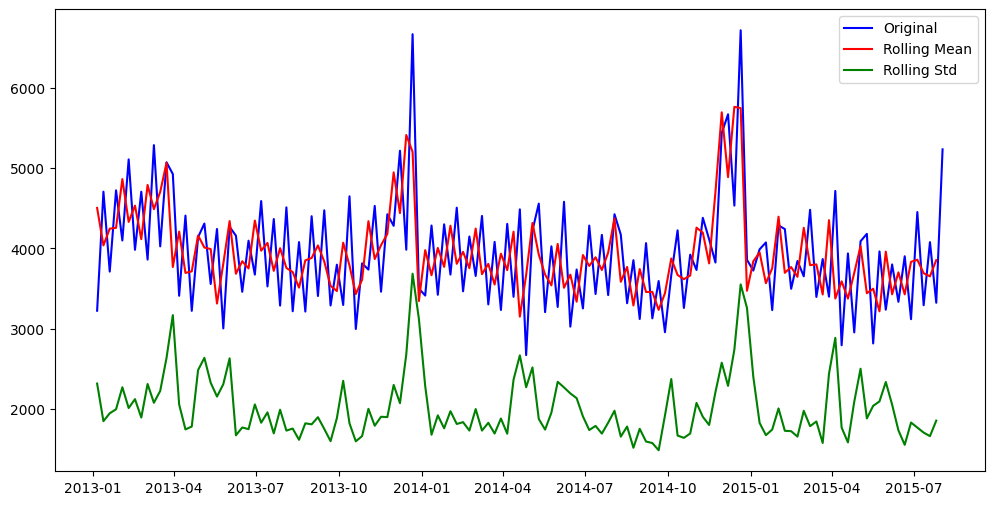

Results of Dickey-Fuller Test:
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


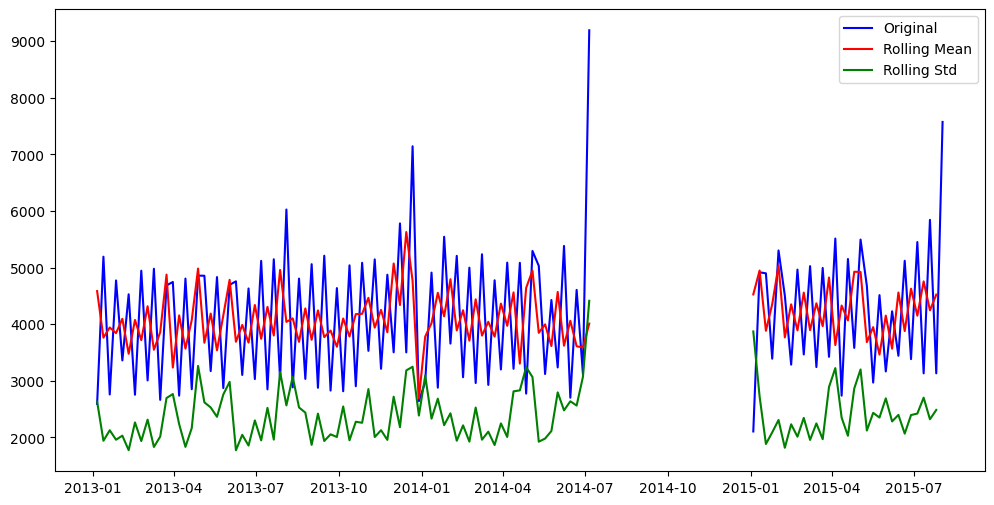

Results of Dickey-Fuller Test:
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [31]:
test_stationarity(df_store_a_2)
test_stationarity(df_store_b_83)
test_stationarity(df_store_c_1)
test_stationarity(df_store_d_13)

In [27]:
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive', period=365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');

    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    plt.title('Decomposition Plots')

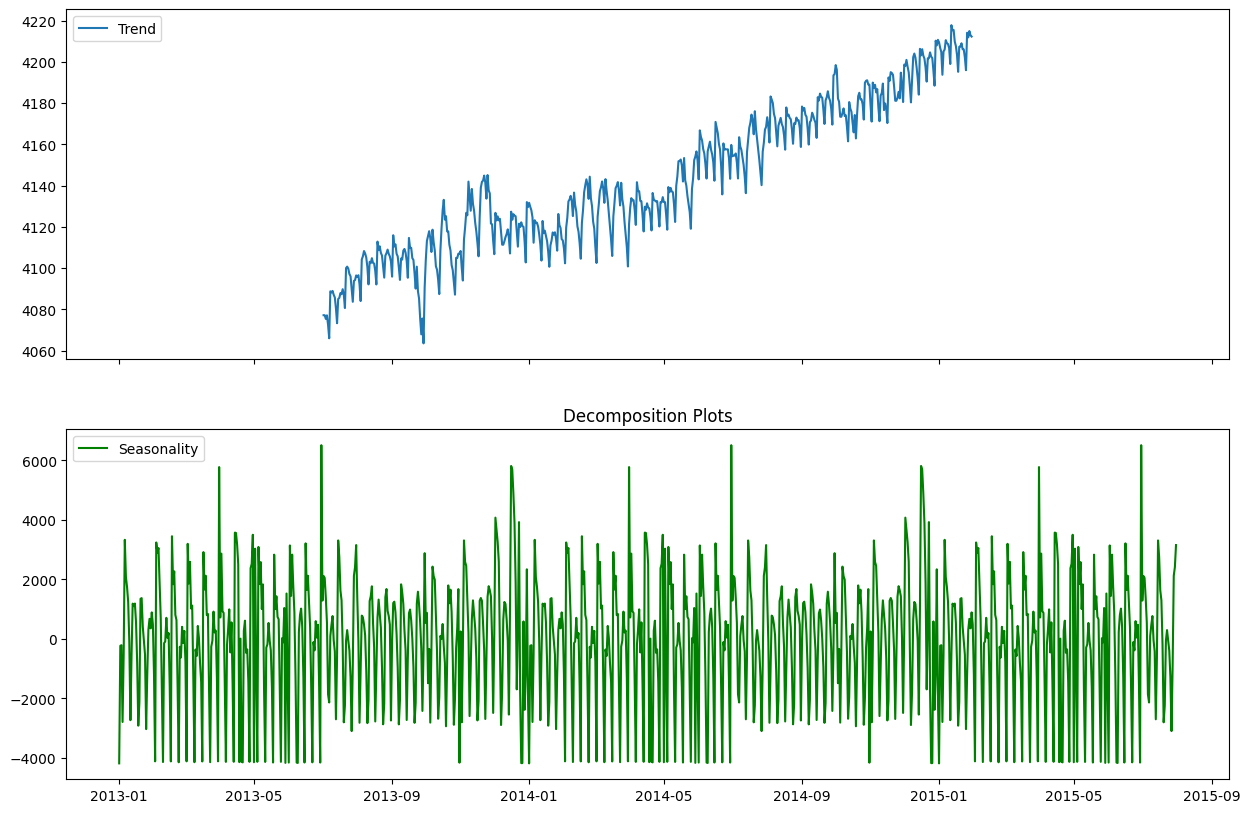

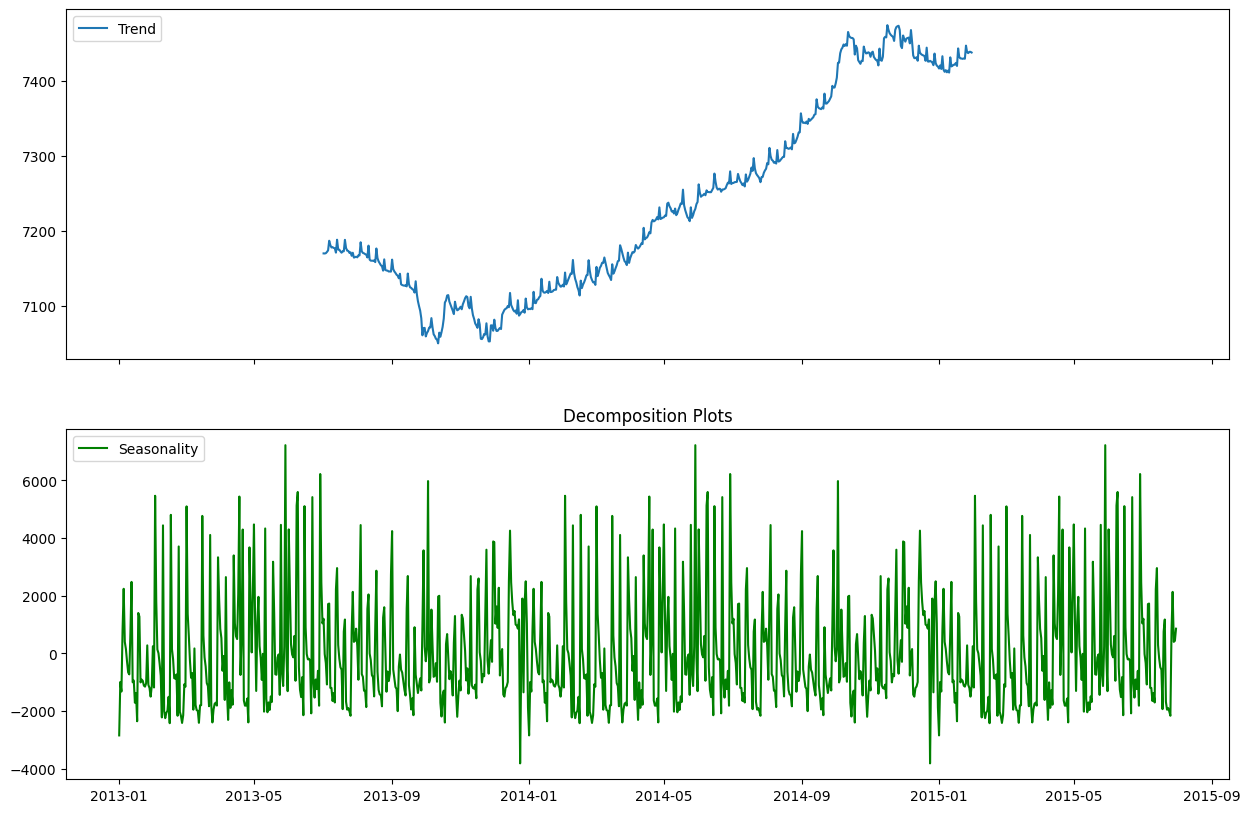

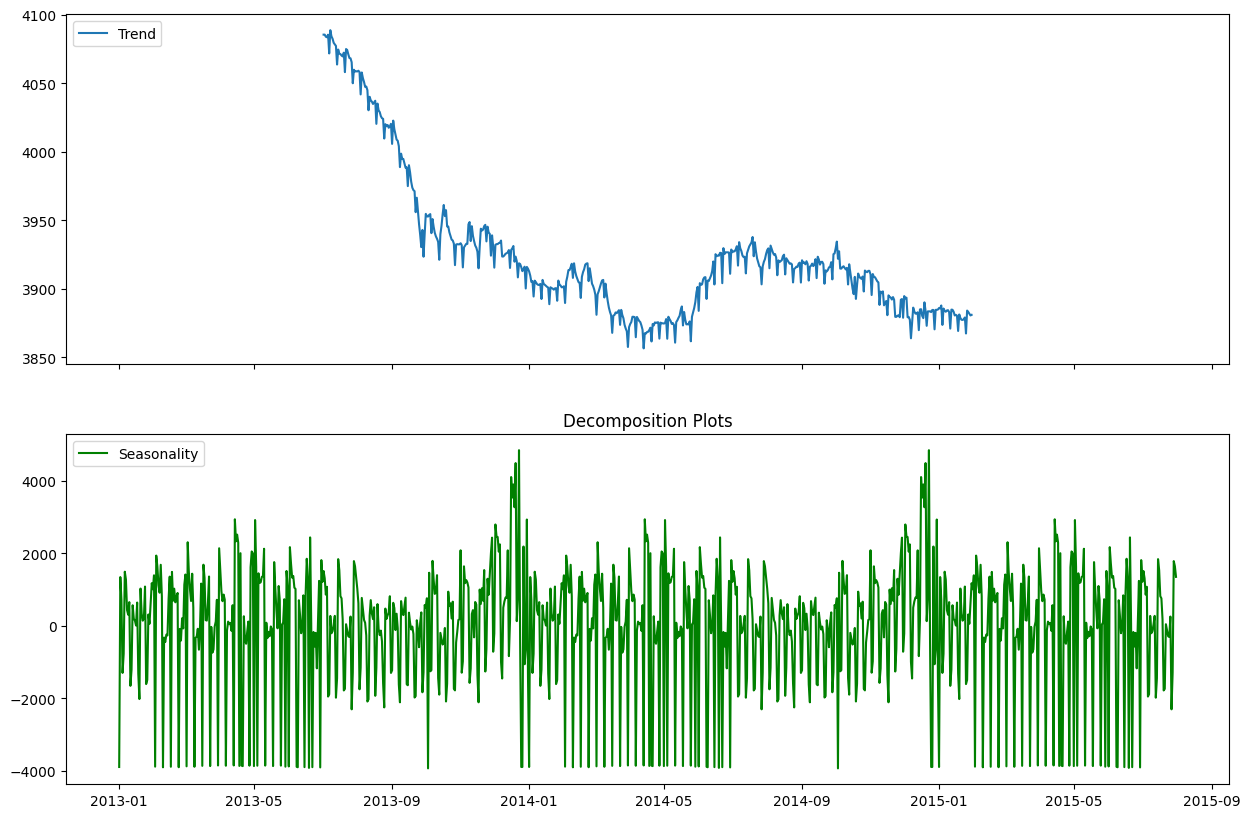

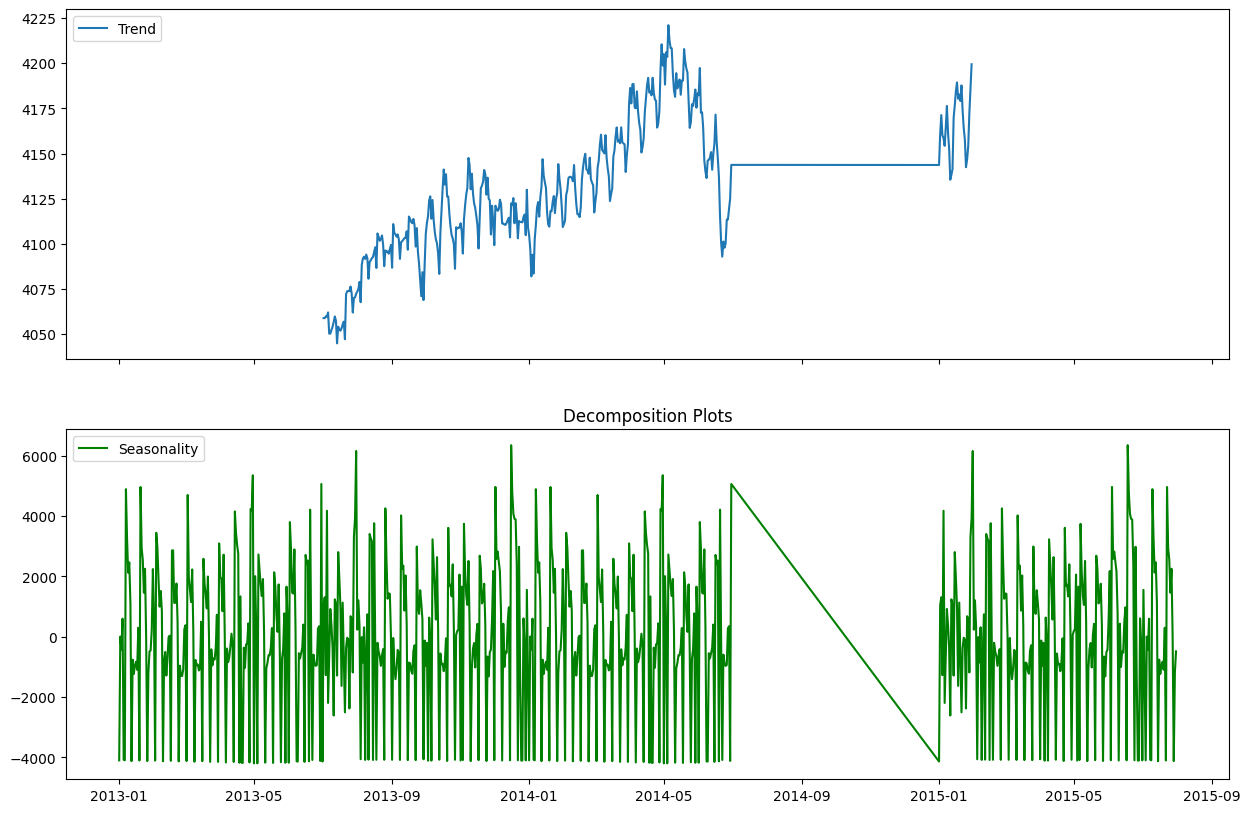

In [32]:
plot_timeseries(df_store_a_2, 'a')
plot_timeseries(df_store_b_83, 'b')
plot_timeseries(df_store_c_1, 'c')
plot_timeseries(df_store_d_13, 'd')

## Studying ACF, PACF

In [33]:
def auto_corr(sales):
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales, nlags=20, method='ols')

    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.title('ACF')

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)),linestyle='--',color ='red')
    plt.title('PACF')

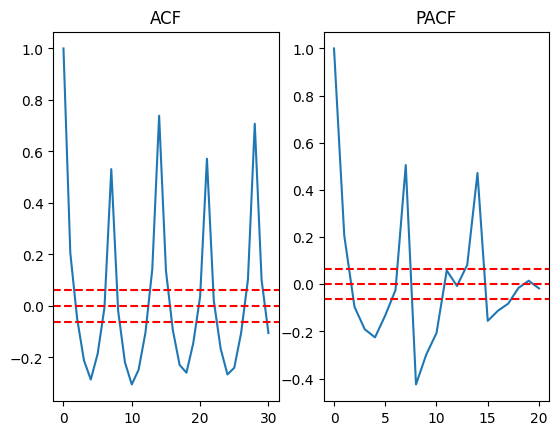

In [35]:
auto_corr(df_store_a_2)

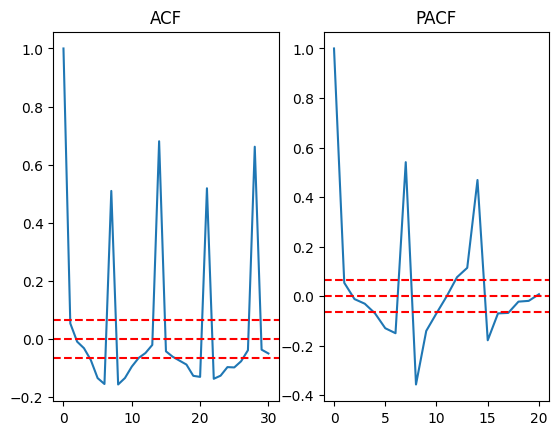

In [36]:
auto_corr(df_store_b_83)

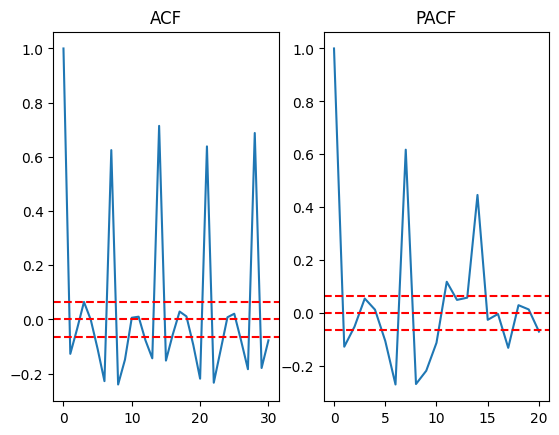

In [37]:
auto_corr(df_store_c_1)

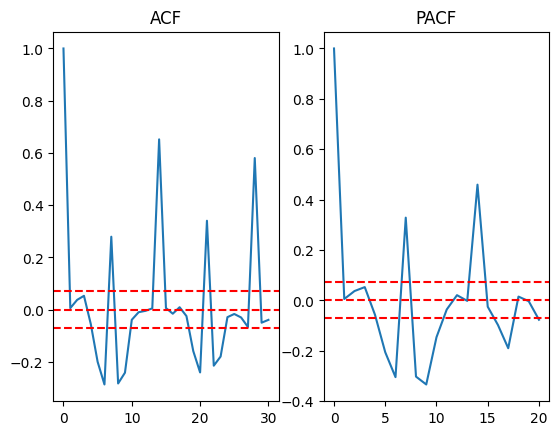

In [38]:
auto_corr(df_store_d_13)

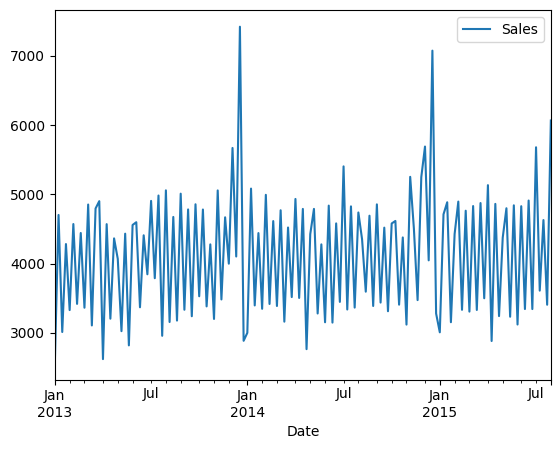

In [40]:
# Summing sales on per week basis
train_arima = df_store_a_2.resample("W").mean()
train_arima = train_arima[["Sales"]]
train_arima.plot();

In [47]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


## Hyperparameter Tuning

In [49]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params, param_seasons, aic = [], [], []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            params.append(param)
            param_seasons.append(param_seasonal)
            aic.append(results.aic)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2620.0533148583036
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2285.0979913740734
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2107.4901918627475
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1851.3646787259702
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2126.519208465022
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2072.663782999095
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1884.3806368189455
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1853.284757713475
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2516.5776796790724
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2243.8868611151215
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2056.966065387694
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1804.7827074340858
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2099.6090681133883
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2001.4784539393388
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1859.918715647477
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1802.7002883370144
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2334.5205490014596
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2122.47521360652

In [51]:
index = aic.index(min(aic))

# Fitting the data to SARIMA model
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                         order=params[index],
                                         seasonal_order=param_seasons[index],
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6084      0.101     -6.009      0.000      -0.807      -0.410
ma.L1         -1.0890      0.048    -22.459      0.000      -1.184      -0.994
ma.S.L12      -1.0099      1.039     -0.972      0.331      -3.047       1.027
sigma2      4.713e+05   5.08e+05      0.928      0.353   -5.24e+05    1.47e+06


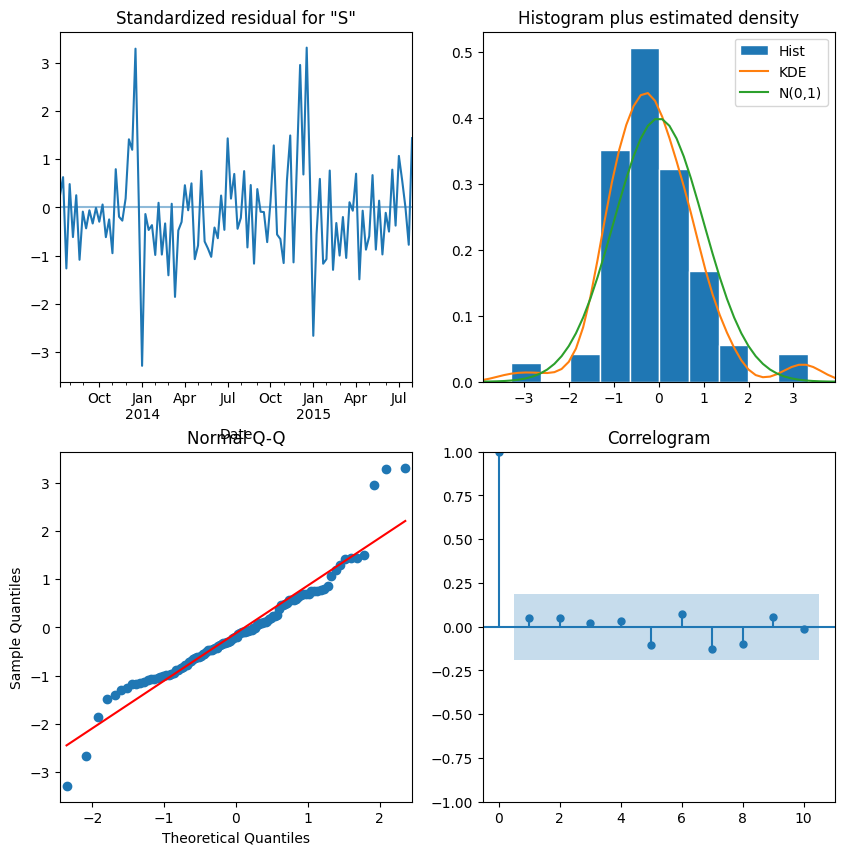

In [52]:
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

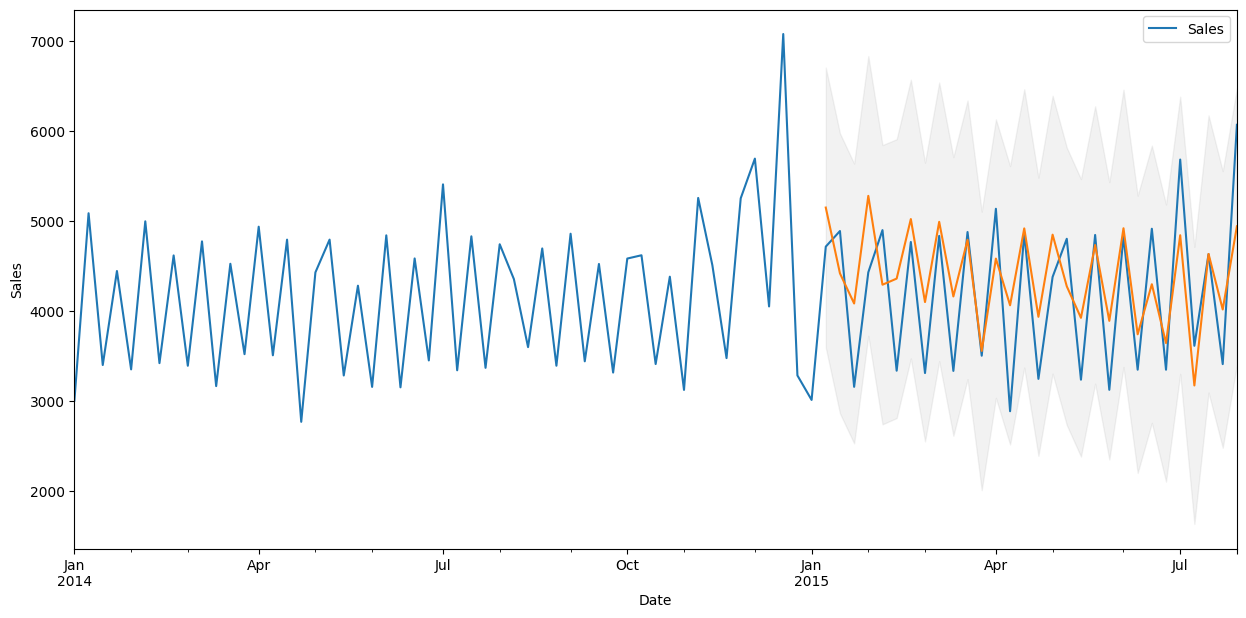

Root Mean Squared Error:  625.4949792096651


In [53]:
# Model Prediction and validation
# Predictions are performed for the 11th Jan' 2015 onwards of the train data.

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic = False)

# Get confidence intervals of forecasts
pred_ci = pred.conf_int()

ax = train_arima["2014":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color = "k", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]

# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)